# 1 Introduction to Spiking Neural Networks (SNN) – D7046E @ LTU.SE

The figure below illustrates a single neuron, see [Figure 1.2A](https://neuronaldynamics.epfl.ch/online/Ch1.S1.html) in Neuronal Dynamics. The dendrite, soma, and axon can be clearly distinguished.

![Neuron](https://neuronaldynamics.epfl.ch/online/x2.png)

Neurons communicate via action potentials that propagate along axons (nerves) to synapses on the dendrites of the target/receiving neurons. The most important feature of an action potential is the **time** when it occurs, while their amplitudes and shapes are similar. In spiking neuron models, action potentials are represented by discrete events called **spikes** that are defined by the time of occurrence and some kind of identifier of the source neuron.

Spiking neuron models mimic natural neurons more closely than the activation-function based *units* of artificial neural networks (ANNs), which operate with *amplitudes* that qualitatively correspond to average spike frequencies. Spiking neurons have time-dependent states and can for example respond differently to two inputs with identical amplitudes but different temporal structure. Spiking neuron models are central in neuroscience and [neuromorphic engineering](https://www.frontiersin.org/journals/neuroscience/sections/neuromorphic-engineering).

In this exercise you will investigate and perform numerical experiments with the leaky integrate-and-fire (LIF) model of neurons, see [Figure 1.6A](https://neuronaldynamics.epfl.ch/online/Ch1.S3.html) in the book and the lectures for further information.

![LIF model](https://neuronaldynamics.epfl.ch/online/x12.png)
<!-- ![LIF model](https://lcnwww.epfl.ch/gerstner/SPNM/img378.gif) -->

In the LIF model we consider the cell membrane (big circle) of the neuron as a capacitor, $C$, that integrates an input current, $I(t)$, of ions from synapses. In addition, there is a parallel branch with a voltage source, $u_{rest}$, and a resistor, $R$, which corresponds to ion pumps and leakage of the cell membrane, respectively. When the membrane voltage, $u(t)$, reaches a threshold voltage, $u_{th}$, a spike is generated and $u(t)$ is reset. See the book for details.

Simulators like [Brian2](https://brian2.readthedocs.io) and [Neuronify](https://ovilab.net/neuronify/) can be used to quickly configure and simulate spiking neural networks (SNNs) of LIF neurons. However, in order to develop an understanding of spiking neurons and neural networks you will solve the corresponding differential equations numerically in this exercise. Some sample code is included below to get you started, and the resulting code will be reused in a subsequent SNN exercise. 

You will also investigate the delta modulator receptor neuron model introduced in the lectures, which introduces a central concept used in neuromorphic sensor systems like [dynamic vision sensors](https://inivation.com/dvp/). The receptor neuron model can be used to convert input signals to spikes that can be further processed with an SNN.

There are 10 mandatory tasks and a few optional tasks that you can perform to deepen your knowledge.

## 1.1 Libraries and generic functions

In [3]:
# Enable inline plots in the notebook
%matplotlib inline

# Import library functions needed
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Set default figure size
plt.rcParams['figure.figsize'] = [10, 10]

# Function that is used to plot spike times
def rasterplot(ax, x, y, x_label, y_label):
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x, y, marker='|')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

## 1.2 LIF neuron model

The LIF model is defined by [Equation 1.5](https://neuronaldynamics.epfl.ch/online/Ch1.S3.html) in the book $$\tau_m \frac{du}{dt} = -(u - u_{rest}) + R I_{syn},$$ where $u=u(t)$ is the membrane potential, $R$ is the membrane resistance and $\tau_m$ is the membrane time constant, which is related to the time constant of the RC electric circuit in the illustration above. Note that $u(t)$ is a voltage difference across the neuron cell membrane.

The equilibrium potential $u_{rest}\simeq-65$ mV is determined by the dynamic equilibrium between the ion flow through channels in the membrane (leakage) and the active ion transport by ion pumps (that maintain a concentration difference). Inside the cell the concentration of ions is different from that in the surrounding liquid. The difference in concentration generates an equilibrium electrical potential called the *Nernst potential* which plays an important role in neuronal dynamics, see [Section 2.1](https://neuronaldynamics.epfl.ch/online/Ch2.S1.html).

Use a threshold membrane potential of $u_{\text th}=-50$ mV and a reset potential of $u_{reset}=u_{rest}$ in the following tasks, unless stated otherwise. Use a membrane time constant of $\tau_m=30$ ms and a membrane resistance of $R=95$ M$\Omega$.

$I_{syn}$ is the total input current to the neuron, which is the sum of postsynaptic currents from all synapses on the neuron. This current can also be defined as a constant injection current to investigate the spike frequency of the LIF neuron for different input currents. This is what you will do in this first task.

**Task 1:** Complete the code below and calculate the membrane potential $u(t)$ for an input current of $I_{syn}=50$ pA. Plot the membrane potential in the interval $t\in[0,1]$ s. Use the Euler forward method to integrate the differential equation with a timestep of $dt=10^{-5}$ s.

**Check your solution:** You can calculate the asymptotic value of u(t) after long time by setting $du/dt=0$ in the differential equation above. This way you can verify that the numerical solution converges to the correct value – which is somewhere between *-61 and -60 mV*.

In [13]:
# Parameters for Tasks 1–5

# Timestep
dt = 1e-5

# Neuron parameters
R       = 95e6  # Membrane resistance [ohms]
tau_m   = 30e-3 # Membrane time constant [seconds]
u_rest  = -65e-3   # Resting potential [mV]
u_reset = u_rest # Reset potential [mV]
u_thres = -50e-3    # Threshold potential [mV]

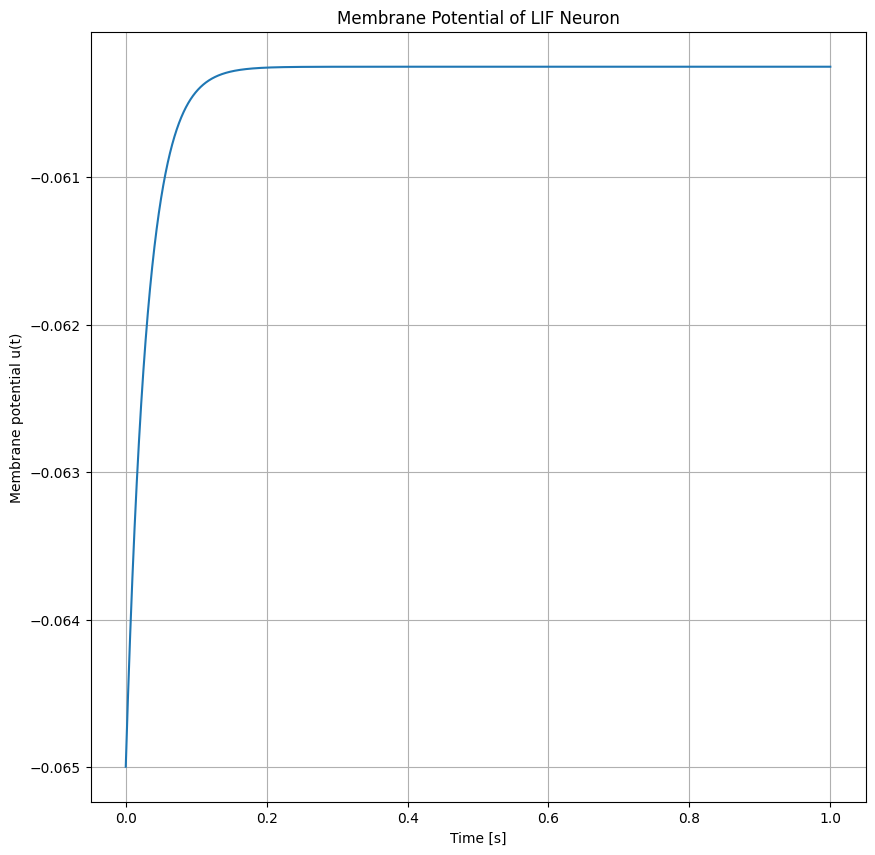

In [24]:
# Set input current from synapses
I_syn = 50e-12  # 50 pA

# function to simulate the membrane potential of a LIF neuron
def simulate_LIF_neuron(I_syn, duration=1, dt=1e-5):

    # Neuron identifier, only one neuron in this simulation
    n_id = 0

    # Initialize parameters
    t_i = []        # Time array
    u_i = []        # Membrane potential array
    t_spike = []    # Spike times
    n_spike = []    # Neuron IDs for spikes

    # Initial conditions
    t = 0
    u = u_rest      # Reset the membrane potential
    
    # Perform the simulation
    while t <= duration:
        # Euler forward step
        du_dt = (-(u - u_rest) + R * I_syn) / tau_m
        u += du_dt * dt
        u_i.append(u)  # Store membrane potential

        # Check for spike condition
        if u >= u_thres:
            t_spike.append(t)    # Record spike time
            n_spike.append(n_id) # Record neuron ID
            u = u_reset         # Reset membrane potential
            
        # Store time
        t_i.append(t)
        t += dt

    return t_i, u_i, t_spike, n_spike

# Perform simulation
t_i, u_i, t_spike, n_spike = simulate_LIF_neuron(I_syn)

# Plot membrane potential
plt.plot(t_i, u_i)
plt.xlabel('Time [s]')
plt.ylabel('Membrane potential u(t)')
plt.title('Membrane Potential of LIF Neuron')
plt.grid()
plt.show()


**Task 2:** Increase the input current $I_{syn}$ and repeat the simulation. At what integer value of the input current $I_{syn}$ in pA does the neuron start spiking? Plot the membrane potential $u(t)$ for this integer value of $I_{syn}$.
    
**Answer:** 158 pA

**Check your solution:** The expression that you derived in the first task for the asymptotic value of $u(t)$ can be used to estimate the current $I_{syn}$ required to reach an asymptotic value of $u_{thres}$. The correct value is between *150 and 160 pA*.

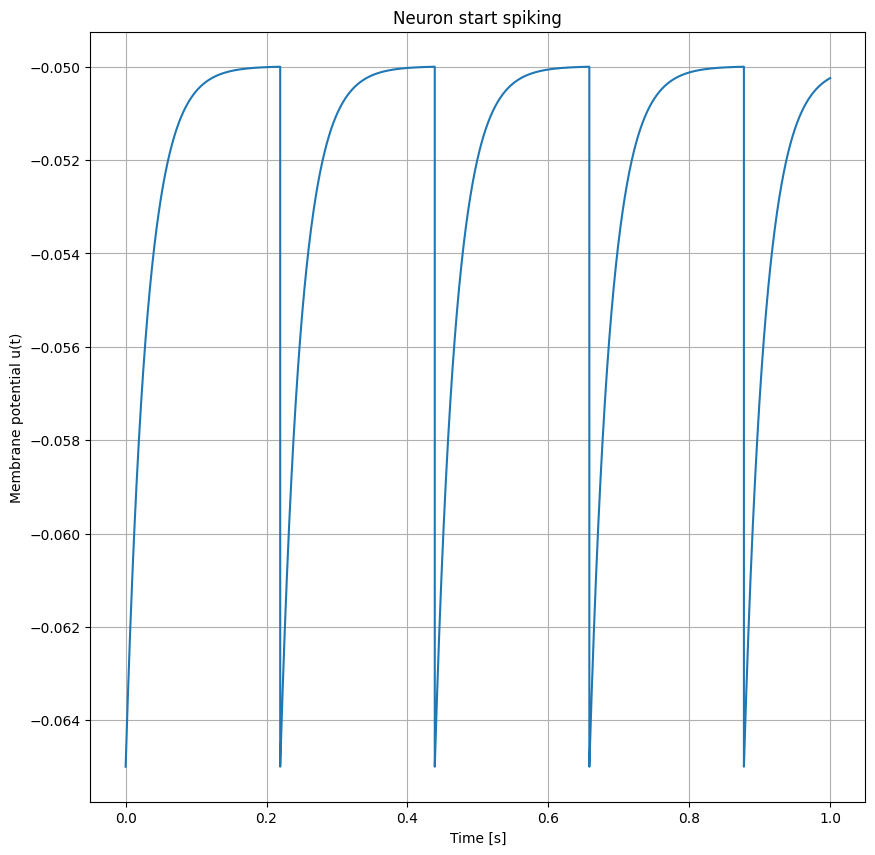

The neuron starts spiking at 158 pA.


In [25]:
# Code for Task 2 

Inc_syn = 1e-12
while True:
    Inc_syn += 1e-12
    t_i, u_i, t_spike, n_spike = simulate_LIF_neuron(Inc_syn)
    if len(t_spike) > 0: 
        break

# Plot membrane potential
plt.plot(t_i, u_i)
plt.xlabel('Time [s]')
plt.ylabel('Membrane potential u(t)')
plt.title('Neuron start spiking')
plt.grid()
plt.show()

# Output the value of I_syn when the neuron starts spiking
print(f"The neuron starts spiking at {Inc_syn*1e12:.0f} pA.")

**Task 3:** Calculate the number of spikes generated during 1 second of simulation time for the input currents 200 pA, 400 pA and 600 pA, respectively. For each value of $I_{syn}$ plot the membrane potential $u(t)$ and the spikes generated using the code provided below.

**Answers:**

* With $I_{syn}=200$ pA there are 21 spikes generated in one second
* With $I_{syn}=400$ pA there are 66 spikes generated in one second
* With $I_{syn}=600$ pA there are 109 spikes generated in one second

**Check your solution:** For an input current of 250 pA you should get 33 spikes in one second of simulation time.

During one second of time 21 spikes were generated for an input current of 200 pA
During one second of time 66 spikes were generated for an input current of 400 pA
During one second of time 109 spikes were generated for an input current of 600 pA
During one second of time 33 spikes were generated for an input current of 250 pA


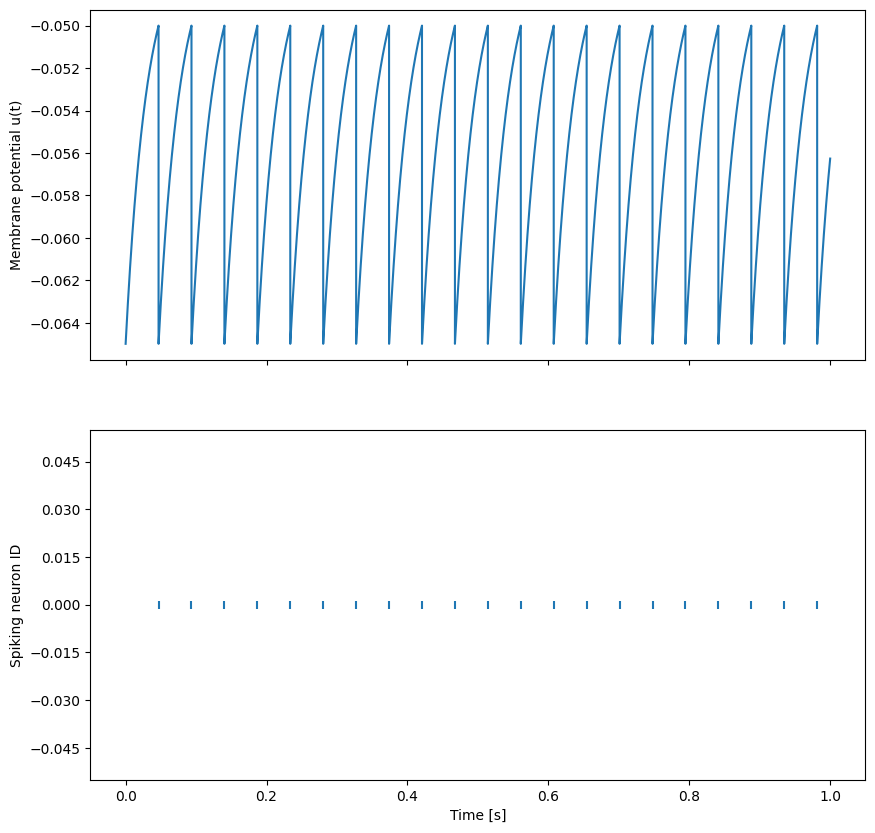

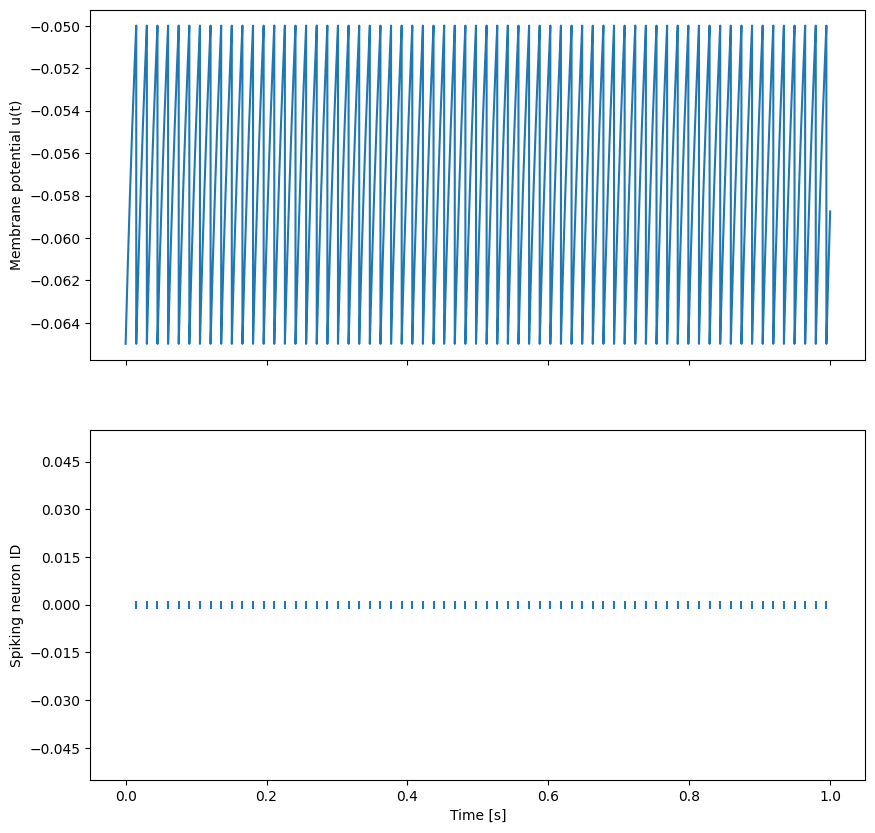

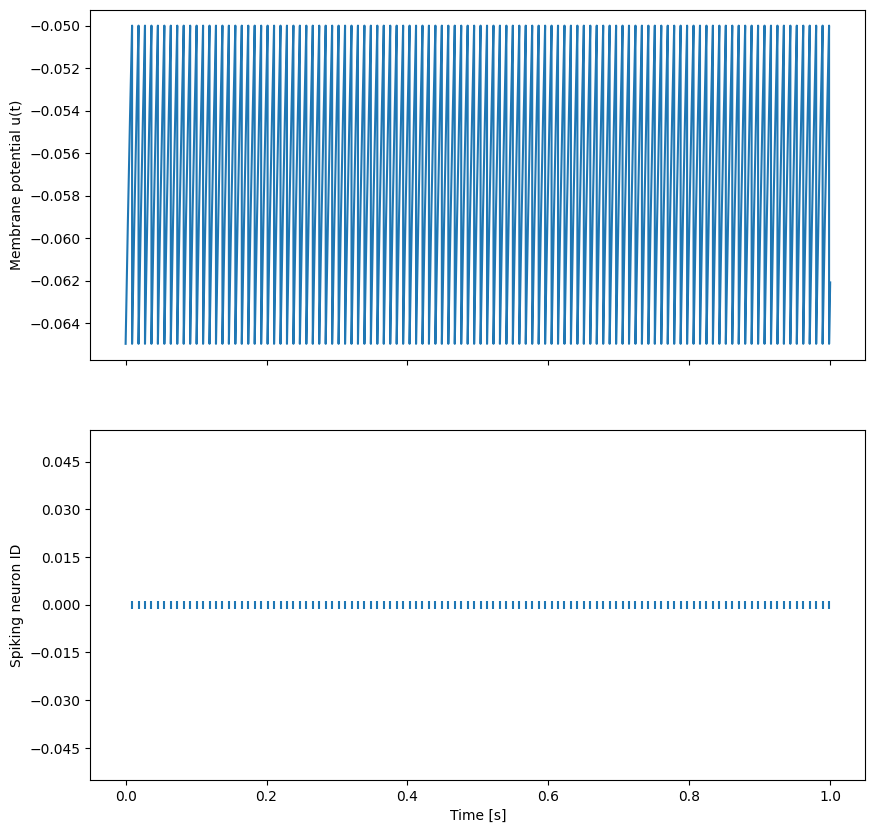

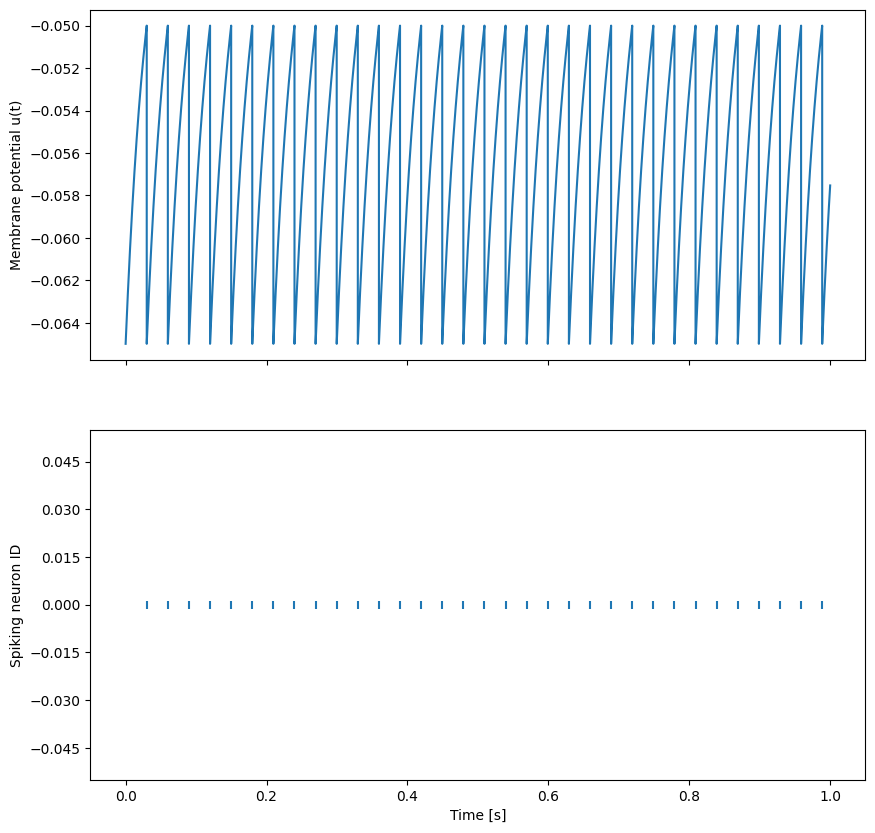

In [27]:
# Code for Task 3

def runTask3(I_syn):
    t_i, u_i, t_spike, n_spike = simulate_LIF_neuron(I_syn)

    print("During one second of time %d spikes were generated for an input current of %d pA" % (len(t_spike),I_syn/1e-12))

    fig,(ax1,ax2) = plt.subplots(2,1, sharex=True)
    ax1.plot(t_i,u_i); ax1.set_ylabel('Membrane potential u(t)')
    rasterplot(ax2, t_spike, n_spike,'Time [s]','Spiking neuron ID')

runTask3(200e-12)
runTask3(400e-12)
runTask3(600e-12)

# Check
runTask3(250e-12)

**Task 4:** Plot the spike frequency in Hz for varying input currents in the range $I_{syn}\in[0, 600]$ pA. This type of plot is called an *f-I Curve* because it illustrates the relation between average spike frequency (f) and stimulus current (I).

**Check your solution:** Compare the result with the answers in Task 3.

**Improve your understanding:** The resulting plot should look similar to the ReLU activation function used in ANNs. Compare your plot with an illustration of the ReLU activation function. What does the horizontal axis represent in the two cases? What does the vertical axis represent in the two cases?

In [ ]:
# Code for Task 4

???
    
ax.set(xlabel='I_syn [pA]', ylabel='Spike rate [Hz]')

### 1.2.1 Pulse input

When a synapse is stimulated by one presynaptic spike a current pulse is generated, see [Figure 3.2](https://neuronaldynamics.epfl.ch/online/Ch3.S1.html) for examples. The amplitude of the current pulse can be a few hundred pA and depends on the efficacy (weight) of the synapse. $I_{syn}$ represents the sum of current pulses from all synapses on the neuron.

In the next task you will investigate the effect on the membrane potential $u(t)$ of one current pulse of varying amplitude and duration, see [Figures 1.6B and 1.7](https://neuronaldynamics.epfl.ch/online/Ch1.S3.html).

**Task 5:** Repeat the simulation with the input current $I_{syn}$ set to a constant value in the time interval $t\in[0,t_{stimuli}]$ and zero otherwise, where $t_{stimuli}$ is an integer number of milliseconds. At what minimum value of $t_{stimuli}$ does the neuron fire one spike for $I_{syn} \in [200, 400, 600]$ pA? Plot the membrane potential and be prepared to explain the relation between [Figure 1.7](https://neuronaldynamics.epfl.ch/online/Ch1.S3.html) in the book and your results.

**Answer:**

For $I_{syn}=200$ pA the neuron fires one spike when $t_{stimuli}$ = ??? milliseconds.

For $I_{syn}=400$ pA ???

For $I_{syn}=600$ pA ???

**Check your solution:** For $I_{syn}=400$ pA, the minimum value of $t_{stimuli}$ for triggering a spike is somwhere between 10 and 20 ms.

In [ ]:
# Code for Task 5

???

### 1.2.2 Limitations of the LIF neuron model

To study neuronal dynamics experimentally, neurons can be isolated and stimulated by current injection through an intracellular electrode, see [Figure 1.13](https://neuronaldynamics.epfl.ch/online/Ch1.S5.html).

![NeuronExperiment](https://neuronaldynamics.epfl.ch/online/x22.png)

A current *I(t)* is experimentally injected in a real neuron with an electrode. The response of the neuron is recorded. Part of the response is used as a training set to optimise the neuron model parameters, while another part of the response is used to cross validate the prediction accuracy of the model.

By testing the prediction accuracy of the LIF model with experimental data it is understood that it neglects several aspects of neuronal dynamics, some of which can be accounted for to improve the prediction accuracy.

**Task 6:** Study [Section 1.4](https://neuronaldynamics.epfl.ch/online/Ch1.S4.html) and [Section 1.5](https://neuronaldynamics.epfl.ch/online/Ch1.S5.html) in the book and *describe* one significant extension that can be made to the LIF neuron model in order to improve the prediction accuracy. Be specific and refer to explicit definitions or descriptions in the book (a figure, equation, sentence etc).

**Answer:** ???

**Optional task:** Can you implement and demonstrate the extension described in Task 6? If so, you are encouraged to document the result and what you have learned from this optional task in your *self-assessment report*, which is considered in the final grading process. See Canvas for further information.

In [ ]:
# Code for optional task


## 1.3 Simulation of a Spiking Neural Network (SNN)

Some additional code is needed to connect multiple LIF neurons into a spiking neural network (SNN). The following code manages the propagation of spikes between interconnected neurons, and also the updating of neurons using the LIF model that you implemented and studied above.

The synapses are implemented using the current-based approximation described in the lectures $$\tau_{syn}\frac{dI_{syn}}{dt}=-I_{syn},$$ where $I_{syn}$ is the postsynaptic current of the synapse and $\tau_{syn}$ is the time constant of the synapse. See [Figure 3.2](https://neuronaldynamics.epfl.ch/online/Ch3.S1.html) and the related discussion of time constants for further information. At the time when a presynaptic spike arrives at the synapse the postsynaptic current is updated by the rule $$I_{syn}\leftarrow I_{syn}+w_{syn},$$ where $w_{syn}$ is the efficacy (weight) of the synapse. For excitatory synapses $w_{syn}\geq 0$, while $w_{syn} \leq 0$ for inhibitory synapses.

This model of the postsynaptic current is more realistic than the current pulse studied in Task 5. The model results in a momentaneous change of $I_{syn}$ by $w$ when a spike arrives, followed by exponential decay of $I_{syn}$ with time constant $\tau_{syn}$ in the absence of stimuli.

### 1.3.1 A basic SNN simulator

In [ ]:
def lif_cic_neuron(I_syn, u_rest=-65e-3, u_reset=-65e-3, u_thres=-50e-3, R=95e6, tau_m=30e-3):
    # LIF neuron with a constant input current I_syn
    return {
        'type'    : 'lif_cic',
        'u'       : u_reset,                   # Membrane potential [Volt]
        'u_rest'  : u_rest,                    # Leakage resting potential [Volt]
        'u_reset' : u_reset,                   # Reset potential after spike [Volt]
        'u_thres' : u_thres,                   # Threshold for spike generation [Volt]
        'R'       : R,                         # Membrane resistance [Ohm]
        'tau_m'   : tau_m,                     # Membrane time constant [second]
        'I_syn'   : I_syn,                     # Postsynaptic current [Ampere]
    }

def lif_neuron(num_synapses, u_rest=-65e-3, u_reset=-65e-3, u_thres=-50e-3, R=95e6, tau_m=30e-3, tau_syn=50e-3):
    # LIF neuron with current-based synapses (see lecture)
    return {
        'type'    : 'lif',
        'u'       : u_reset,                   # Membrane potential [Volt]
        'u_rest'  : u_rest,                    # Leakage resting potential [Volt]
        'u_reset' : u_reset,                   # Reset potential after spike [Volt]
        'u_thres' : u_thres,                   # Threshold for spike generation [Volt]
        'R'       : R,                         # Membrane resistance [Ohm]
        'tau_m'   : tau_m,                     # Membrane time constant [second]
        'tau_syn' : tau_syn,                   # Synapse time constant [second] (can also be an array)
        'I_syn'   : np.zeros(num_synapses),    # Postsynaptic currents [Ampere]
        'w_syn'   : np.zeros(num_synapses)     # Synaptic weights [Ampere]
    }

def integrate(dt, t, neurons):
    # This function integrates the membrane potential, synaptic currents etc one timestep dt
    for n in neurons:
        if n['type'] == 'lif_cic':
            dudt = (n['u_rest'] - n['u'] + n['R']*n['I_syn']) / n['tau_m']
            n['u'] += dt*dudt
        elif n['type'] == 'lif':
            didt = np.divide(-n['I_syn'], n['tau_syn'])
            n['I_syn'] += dt*didt
            dudt = (n['u_rest'] - n['u'] + n['R']*sum(n['I_syn'])) / n['tau_m']
            n['u'] += dt*dudt

def spikegen(dt, t, neurons):
    # This function implements the non-linear spike generation mechanism
    spikes = []
    for i,n in enumerate(neurons):
        if n['type'] in ['lif_cic','lif']:
            if n['u'] > n['u_thres']:
                n['u'] = n['u_reset']
                spikes.append(i)
    return spikes

def snn_update(dt, t, neurons, connections):
    # This function updates the state of a spiking neural network by calling the functions above
    spikes = spikegen(dt, t, neurons)
    for (post, syn, pre) in connections:
        for spike in spikes:
            if spike == pre:
                if neurons[post]['type'] == 'lif':
                    neurons[post]['I_syn'][syn] += neurons[post]['w_syn'][syn]
                else:
                    print('Error: Spike sent to neuron type without synapses')
    integrate(dt, t, neurons)
    return spikes

### 1.3.2 Example: Define a population of neurons

In [ ]:
n0 = lif_cic_neuron(200e-12);        # LIF neuron with constant input current of 200 pA

n1 = lif_neuron(1);                  # LIF neuron with one dynamic synapse
n2 = lif_neuron(2);                  # LIF neuron with two dynamic synapses

neurons = [n0, n1, n2]               # A population of three neurons

t = 0                                # Reset the simulation time

### 1.3.3 Example: Connect the neurons

Given an array of neurons, each connection between two neurons is defined by three integers:

0. The index of the postsynaptic neuron (the destination), here referred to as 'post'.
1. The index of the synapse on the postsynaptic neuron, here referred to as 'syn'.
2. The index of the presynaptic neuron (the source), here referred to as 'pre'.

Thus, an array defining all connections has the following structure  

    connections = [[post,syn,pre], [post,syn,pre], ... ]

Each triplet [post, syn, pre] configures one connection between two neurons via one synapse

$$post : syn \leftarrow  pre$$

In [ ]:
connections = [[1,0,0],    # n1 receives spikes from n0 on synapse 0
               [2,0,0],    # n2 receives spikes from n0 on synapse 0
               [2,1,1]]    # n2 also receives spikes from n1 on synapse 1

n1['w_syn'][0] = 300e-12   # Excitatory synapse with weight 300 pA

n2['w_syn'][0] = 300e-12   # Excitatory synapse with weight 300 pA
n2['w_syn'][1] = -100e-12  # Inhibitory synapse with weight -100 pA

### 1.3.4 Example: Integrate equations over time

Integrate the equations describing the dynamics of neurons and synapses over time and store any variables needed for plotting at each time step. **Observe** that the neurons are stateful, you have to re-run Cell 1.3.2 where the neuron population is defined to reset the simulation.

In [ ]:
dt = 1e-5

t0 = t
tv = []
u1 = []
u2 = []
t_spike = []
n_spike = []

while t < t0+1:

    # Update the network
    spikes = snn_update(dt, t, neurons, connections)
    
    # Store membrane potentials of n1 and n2 for plotting/analysis
    tv.append(t)
    u1.append(n1['u'])
    u2.append(n2['u'])
    
    # Store spikes needed for plotting/analysis
    if len(spikes)>0:
        for s in spikes:
            t_spike.append(t)
            n_spike.append(s)

    # Timestep completed
    t += dt
    
plt.rcParams['figure.figsize'] = [10, 10]
fig,(ax1,ax2,ax3) = plt.subplots(3,1, sharex=True)
ax1.plot(tv,u2); ax1.set_ylabel('Membrane potential u2(t)')
ax2.plot(tv,u1); ax2.set_ylabel('Membrane potential u1(t)')
rasterplot(ax3, t_spike, n_spike,'Time [s]','Neuron index')

**Task 7:** How many times does neuron n2 spike in the simulation above, and why does it spike with a lower frequency than n1 although both neurons have excitatory synapses with the same weight? Be prepared to motivate your answer.

**Answer:** ???

### 1.3.5 Implementing your first SNN

**Task 8:** Define a new neuron population and new connections between these neurons. Investigate what happens when one LIF neuron called nsum receives spike inputs from multiple LIF neurons with constant input currents (lif_cic neurons) of I_syn = 200 pA. What is the spike rate of nsum for one input, two inputs, three inputs etc? Use excitatory synapses with weights 300 pA. How much does the spike rate increase for each additional input?

Run the simulation for 1 second before starting the spike rate estimation (there is an initial delay before the neuron starts spiking that can affect the spike rate estimation otherwise).

**Answer:**

With one input neuron the spike rate is ???

With two input neurons ???

???

**Check your solution:** With one input neuron, the spike rate should be between 40 and 50 Hz. With two input neurons, between 110 and 120 Hz.

In [ ]:
# Code for Task 8

in1 = lif_cic_neuron(200e-12);
in2 = lif_cic_neuron(200e-12);
...

nsum = lif_neuron(5);
nsum['w_syn'][0] = 300e-12
...

neurons = [nsum, in1, ...
           
connections = ...

...

**Optional task:** Can you implement another SNN example available in [Neuronify](https://ovilab.net/neuronify/) using this code? If so, you are encouraged to document the result and what you have learned from this optional task in your self-assessment report. Task 8 is inspired by one of the Neuronify examples, which one?

In [ ]:
# Code for optional task


### 1.3.6 Hint for Retina project
There is a direction selective network example in [Neuronify](https://ovilab.net/neuronify/) that can be used as inspiration to construct a basic motion detection network for the Retina project using the SNN simulator developed in this exercise. In the next SNN exercise you will implement synaptic plasticity, which is the primary mechanism for learning in SNNs.

In the final part of this exercise you will investigate a method that is useful for converting arbitrary analog/sampled signals into spike patterns, which can be processed with an SNN.

## 1.4 Sensory neurons and the delta modulator model

Sensory neurons convert a specific type of stimulus like light, sound or touch intensity into action potentials (or in some cases also graded non-spiking potentials not further discussed here). This process is called sensory transduction. Refer to https://en.wikipedia.org/wiki/Sensory_neuron for a an overview.

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/1/17/Structure_of_sensory_system_%284_models%29_E.PNG" width="400"/>
</div>

Neural encoding concerns the map from stimulus to response and investigating how neurons respond to different stimuli, as well as construction of models that predict the responses for novel stimuli (generalization). This is an active area of research. See [Section 7.6.2](https://neuronaldynamics.epfl.ch/online/Ch7.S6.html) for information about different candidate encoding concepts. If you are interested to study the details of sensory neurons and systems, the book [Neuroscience](https://www.bokus.com/bok/9781605358413/neuroscience/) by Dale Purves et. al. is recommended because of the many helpful illustrations and in-depth biological presentations.

In the final part of this exercise you will investigate the asynchronous delta modulator model that is introduced in the lecture about sensory systems. This concept is used to map analog voltages and currents to spikes in neuromorphic sensors like [brain machine interfaces](https://doi.org/10.1109/TBCAS.2015.2479256) and [neuromorphic vision sensors](https://en.wikipedia.org/wiki/Event_camera).

The idea is to measure *differences* in the intensity/amplitude of the signal and generate a spike whenever the intensity increases or decreases by an anount $\delta$, hence the name *asynchronous delta modulator*. The figure below illustrates the idea. There are two output neurons for each signal in this model, denoted *UP* and *DN*, which fires a spike whenever the intensity increases (UP) or decreases (DN).

![Delta modulator concept](https://drive.google.com/uc?export=view&id=1VYCbScz6k5yvhwb0h6XYDdLQ-q_3KgAh)

The intensity is typically a logarithmic function of the signal amplitude in biology and neuromorphic systems, leading to sensor systems with high [dynamic range](https://en.wikipedia.org/wiki/Dynamic_range).

### 1.4.1 Encoder function

The delta modulator encodes one time-varying signal $y(t)$ in two spiketrains representing positive and negative amplitude changes in discrete steps $\pm\delta_y$. The amplitude resolution and average spikerate depends on the parameter $\delta_y$. This is similar to pulse interval/frequency modulation, which may be familiar if you have studied digital communication.

**Task 9:** Complete the encoder implementation below so that it generates UP and DN spikes from an input sequence $y_i(t_i)$ as described in the figure above. Whenever the amplitude $y$ has increased by an amount $\delta_y$ an up spike should be generated. If the amplitude $y$ decreases by an amount $\delta_y$ a down spike should be generated. The list of generated up and down spike times should be returned from the encoder function. The subsequent example *Encoding a sine wave* and Task 10 should be used to verify that your encoder implementation is correct.

In [ ]:
def delta_encode(t,y,deltay):
    
    # Arrays of spike times
    t_up = []
    t_dn = []
    
    # Initial values of time and signal amplitude y
    tprev = t[0];
    yprev = y[0];
    
    # For each time step and signal amplitude value
    for ti, yi in zip(t[1:], y[1:]):

        # Amplitude change since last spike
        dy = ???
        
        # Number of spikes generated 
        nspikes = int( ??? ) # round towards zero
        
        # Generate up/down spike times
        if nspikes != 0:
        
            # Time step between spikes
            dt = abs( ??? ) ???
            
            # Append spike times to the arrays
            if nspikes > 0:
                t_up.append(np.arange(1,1+nspikes)*dt + tprev)
                tprev = t_up[-1]
            elif nspikes < 0:
                t_dn.append(np.arange(1,1-nspikes)*dt + tprev)
                tprev = t_dn[-1]
            
            # Update the y value corresponding to the last (previous) spike
            yprev += nspikes*deltay
            
    return t_up, t_dn

### Example: Encoding a sine wave

Example where a sine wave is encoded with the delta modulator. The resulting up and down spike times are visualised. Use this example to check that your encoder implementation produces reasonable output spike times. Modify the $\delta_y$ parameter and note how the UP/DN spike outputs are affected.

In [ ]:
# Define time array t

dt = 1e-4                  # 0.1 millisecond steps
t = np.arange(1,10000)*dt

# Define 5 Hz sine wave y(t)
frequency = 5
omega = 2.0*3.1415*frequency
y = np.sin(omega*t)

# Encode signal y(t) with spike times using the delta modulator
dy = 0.2
(t_up, t_dn) = delta_encode(t,y,dy)

# Plot the result
fig,(ax1,ax2,ax3) = plt.subplots(3,1, sharex=True)
ax1.plot(t,y); ax1.set_ylabel('Signal, y(t)');
rasterplot(ax2, t_up, np.ones(len(t_up)),'Time [s]','Up spikes')
rasterplot(ax3, t_dn, np.ones(len(t_dn)),'Time [s]','Down spikes')

### Decoding

Decoding refers to the reverse map, from spike response to reconstructed stimulus. To decode the sequence of up- and down spikes generated by the delta modulator encoder into a time-varying signal $y_i(t_i)$ the process is reversed by the operations $y = y+\delta_y$ at the time of every UP spike and $y = y-\delta_y$ at the time of every DN spike. The decoding function is provided below. 

In [ ]:
def delta_decode(deltay, t_up, t_dn):
    t = [0]
    y = [0]
    i=j=0
    while 1:
        if i < len(t_up) and j < len(t_dn):
            if t_up[i] < t_dn[j]:
                y.append(y[-1]+deltay)
                t.append(t_up[i])
                i += 1
            elif t_dn[j] < t_up[i]:
                y.append(y[-1]-deltay)
                t.append(t_dn[j])
                j += 1
        elif i < len(t_up):
            y.append(y[-1]+deltay)
            t.append(t_up[i])
            i += 1
        elif j < len(t_dn):
            y.append(y[-1]-deltay)
            t.append(t_dn[j])
            j += 1
        else:
            break
            
    return t, y

**Task 10:** Run the following code to verify that your encoder implemented in Task 9 produces UP/DN spikes that enables correct decoding of the signal. Plot the reconstructed signal for different values of $\delta_y \in [0.4, 0.3, 0.2, 0.1, ...]$.

**Check your solution:** For small values of $\delta_y$ the reconstructed signal should appear identical to the original 5 Hz sine wave.

In [ ]:
dt = 1e-4                  # 0.1 millisecond steps

# Time array t
t = np.arange(1,10000)*dt

# 5 Hz sine wave y(t)
frequency = 5
omega = 2.0*3.1415*frequency
y = np.sin(omega*t)

# Encode signal y(t) with spike times using the delta modulator
dy = 0.1
(t_up, t_dn) = delta_encode(t, y, dy)

# Reconstruct signal with decoder
(tr, yr) = delta_decode(dy, t_up, t_dn)

# Plot the result
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1, sharex=True)
ax1.plot(t,y); ax1.set_ylabel('Signal, y(t)');
rasterplot(ax2, t_up, np.ones(len(t_up)),'Time [s]','Up spikes')
rasterplot(ax3, t_dn, np.ones(len(t_dn)),'Time [s]','Down spikes')
ax4.plot(tr,yr); ax4.set_ylabel('Reconstruction, r(t)');

**Optional task:** Extend the basic SNN simulator above so that an SNN can receive inputs from sensory neurons implemented with the delta modulator encoder. Modify the encoding function so that you can stimulate an SNN with an arbitrary signal of type $y_i(t_i)$. Can you implement the *reciprocal inhibition* example in [Neuronify](https://ovilab.net/neuronify/) using your extended simulator, so that the circuit selectively can ouput only UP or DN events? Do you see some similarity between the behaviour of this simple circuit and the concept of attention in cognition? You are encouraged to document the result and what you have learned from this optional task in your self-assessment report.

In [ ]:
# Code for optional task


### Additional references

[Python exercise on LIF neurons](https://neuronaldynamics-exercises.readthedocs.io/en/latest/exercises/leaky-integrate-and-fire.html) based on Brian2 at the website of the Neuronal Dynamics course book.